## Running seisflows following 2D Example Walkthrough
https://seisflows.readthedocs.io/en/devel/2D_example_walkthrough.html   
by AR  

In [1]:
import os
import glob
import shutil
import time
import numpy as np
from IPython.display import Image

In [2]:
t0 = time.time()
WORKDIR = os.getcwd()
SPECFEM2D = "/home/scoped"
# where WORKDIR: points to working directory
# and SPECFEM2D: points to an existing specfem2D repository if available (if not set as '')

# The SPECFEM2D working directory that we will create separate from the downloaded repo
SPECFEM2D_WORKDIR = os.path.join(WORKDIR, "specfem2d_workdir")
SPECFEM2D_BIN = os.path.join(SPECFEM2D_WORKDIR, "bin")
SPECFEM2D_DATA = os.path.join(SPECFEM2D_WORKDIR, "DATA")
SPECFEM2D_OUTPUT = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES")

# Pre-defined locations of velocity models we will generate using the solver
SPECFEM2D_MODEL_INIT = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES_INIT")
SPECFEM2D_MODEL_TRUE = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES_TRUE")

In [3]:
!seisflows -h

usage: seisflows [-h] [-w [WORKDIR]] [-p [PARAMETER_FILE]]
                 {setup,configure,swap,submit,resume,restart,clean,par,sempar,check,init,plot2d,plotst,print,reset,debug,examples}
                 ...


                     SeisFlows: Waveform Inversion Package                      


options:
  -h, --help            show this help message and exit
  -w [WORKDIR], --workdir [WORKDIR]
                        The SeisFlows working directory, default: cwd
  -p [PARAMETER_FILE], --parameter_file [PARAMETER_FILE]
                        Parameters file, default: 'parameters.yaml'

command:
  Available SeisFlows arguments and their intended usages

    setup               Setup working directory from scratch
    configure           Fill parameter file with defaults
    swap                Swap module parameters in an existing parameter file
    submit              Submit initial workflow to system
    resume              Re-submit previous workflow to system
    restart            

## Populate Par_file

In [4]:
# The command 'setup' creates the 'parameters.yaml' file that controls all of SeisFlows
# the '-f' flag removes any exist 'parameters.yaml' file that might be in the directory
os.chdir(WORKDIR)
!seisflows setup -f
!ls

created parameter file: parameters.yaml
A_CreateInitialandTrueModels.ipynb  parameters.yaml
B1_RunSeisflows_Complete.ipynb	    specfem2d_workdir
B2_RunSeisflows_Stopping.ipynb


In [5]:
# Let's have a look at this file, which has not yet been populated
!cat parameters.yaml


# //////////////////////////////////////////////////////////////////////////////
#
#                        SeisFlows YAML Parameter File
#
# //////////////////////////////////////////////////////////////////////////////
#
# Modules correspond to the structure of the source code, and determine
# SeisFlows' behavior at runtime. Each module requires its own sub-parameters.
#
# .. rubric::
#   - Determine available options for modules by running:
#       > seisflows print modules
#   - Auto-fill with docstrings and default values (recommended) by running:
#       > seisflows configure
#   - Swap out module parameters for a configured parameter file by running:
#       > seisflows swap {module} {name} (e.g., seisflows swap solver specfem3d)
#   - To set values as NoneType, use: null
#   - To set values as infinity, use: inf
#
#                                    MODULES
#                                    ///////
# workflow (str):    The types and order of functions for running SeisFlows

In [6]:
# We can use the `seisflows print modules` command to list out the available options
!seisflows print modules

                               SEISFLOWS MODULES                                
                               /////////////////                                
'-': module, '*': class

- workflow
    * forward
    * inversion
    * migration
    * test_flow
- system
    * chinook
    * chinook_singularity
    * cluster
    * frontera
    * lsf
    * maui
    * singularity
    * slurm
    * workstation
- solver
    * specfem
    * specfem2d
    * specfem3d
    * specfem3d_globe
- preprocess
    * default
    * pyaflowa
- optimize
    * LBFGS
    * NLCG
    * gradient


In [7]:
# For this example, we can use most of the default modules, however we need to
# change the SOLVER module to let SeisFlows know we're using SPECFEM2D (as opposed to 3D)
!seisflows par workflow inversion
!seisflows par preprocess pyaflowa
!seisflows par optimize LBFGS
!cat parameters.yaml

workflow: forward -> inversion
preprocess: default -> pyaflowa
optimize: gradient -> LBFGS

# //////////////////////////////////////////////////////////////////////////////
#
#                        SeisFlows YAML Parameter File
#
# //////////////////////////////////////////////////////////////////////////////
#
# Modules correspond to the structure of the source code, and determine
# SeisFlows' behavior at runtime. Each module requires its own sub-parameters.
#
# .. rubric::
#   - Determine available options for modules by running:
#       > seisflows print modules
#   - Auto-fill with docstrings and default values (recommended) by running:
#       > seisflows configure
#   - Swap out module parameters for a configured parameter file by running:
#       > seisflows swap {module} {name} (e.g., seisflows swap solver specfem3d)
#   - To set values as NoneType, use: null
#   - To set values as infinity, use: inf
#
#                                    MODULES
#                            

In [8]:
# The seisflows configure command populates the parameter file based on the chosen modules. 
# SeisFlows will attempt to fill in all parameters with reasonable default values. 
!seisflows configure
!head --lines=50 parameters.yaml

configuring SeisFlows parameter file
L-BFGS optimization requires 'backtrack'ing line search. Overwriting 'bracket'

# //////////////////////////////////////////////////////////////////////////////
#
#                        SeisFlows YAML Parameter File
#
# //////////////////////////////////////////////////////////////////////////////
#
# Modules correspond to the structure of the source code, and determine
# SeisFlows' behavior at runtime. Each module requires its own sub-parameters.
#
# .. rubric::
#   - Determine available options for modules by running:
#       > seisflows print modules
#   - Auto-fill with docstrings and default values (recommended) by running:
#       > seisflows configure
#   - Swap out module parameters for a configured parameter file by running:
#       > seisflows swap {module} {name} (e.g., seisflows swap solver specfem3d)
#   - To set values as NoneType, use: null
#   - To set values as infinity, use: inf
#
#                                    MODULES
#   

In [9]:
# EDIT THE SEISFLOWS PARAMETER FILE
!seisflows par ntask 3  # set the number of sources/events to use
!seisflows par nproc 1  # set the number of sources/events to use
!seisflows par materials elastic  # update Vp and Vs during inversion
!seisflows par start 1  # initial iteration -- we will only run 1
!seisflows par end 5    # final iteration -- we will only run 1
!seisflows par data_case synthetic  # synthetic-synthetic means we need both INIT and TRUE models
!seisflows par components Y  # this default example creates Y-component seismograms
!seisflows par adj_src_type cc   # options: 'cc': cross-correlation, 'mt': multitaper, 'wav': waveform
!seisflows par step_count_max 10  # limit the number of steps in the line search
!seisflows par smooth_h 5000  # smoothing distance 
!seisflows par smooth_v 5000  # smoothing distance
!seisflows par min_period 10  # tmin
!seisflows par max_period 200 # tmax
!seisflows par filter_corners 4 # limit the number of steps in the line search
!seisflows par plot True #Plot waveform figures and source receiver maps during the preprocessing stage

# Use Python syntax here to access path constants
os.system(f"seisflows par path_specfem_bin {SPECFEM2D_BIN}")  # set path to SPECFEM2D binaries
os.system(f"seisflows par path_specfem_data {SPECFEM2D_DATA}")  # set path to SEPCFEM2D DATA/
os.system(f"seisflows par path_model_init {SPECFEM2D_MODEL_INIT}")  # set path to INIT model
os.system(f"seisflows par path_model_true {SPECFEM2D_MODEL_TRUE}")  # set path to TRUE model

ntask: 1 -> 3
nproc: 1 -> 1
materials: acoustic -> elastic
start: 1 -> 1
end: 1 -> 5
data_case: data -> synthetic
components: ZNE -> Y
adj_src_type: cc -> cc
step_count_max: 10 -> 10
smooth_h: 0.0 -> 5000
smooth_v: 0.0 -> 5000
min_period: 1.0 -> 10
max_period: 10.0 -> 200
filter_corners: 4 -> 4
plot: True -> True
path_specfem_bin: null -> /home/scoped/work/specfem2d_workdir/bin
path_specfem_data: null -> /home/scoped/work/specfem2d_workdir/DATA
path_model_init: null -> /home/scoped/work/specfem2d_workdir/OUTPUT_FILES_INIT
path_model_true: null -> /home/scoped/work/specfem2d_workdir/OUTPUT_FILES_TRUE


0

In [10]:
# edit the SPECFEM2D Par_file parameter MODEL such that xmeshfem2d reads our pre-built velocity models 
# (*.bin files) rather than the meshing parameters defined in the Par_file.
os.chdir(SPECFEM2D_DATA)
!seisflows sempar model gll
!seisflows sempar use_existing_STATIONS .true.

MODEL: legacy -> gll
use_existing_STATIONS: .false. -> .true.


## Run seisflows 

### Forward simulation

In [11]:
os.chdir(WORKDIR)
!seisflows print tasks

                          SEISFLOWS WORKFLOW TASK LIST                          
                          ////////////////////////////                          
Task list for <class 'seisflows.workflow.inversion.Inversion'>

1: evaluate_initial_misfit
2: run_adjoint_simulations
3: postprocess_event_kernels
4: evaluate_gradient_from_kernels
5: initialize_line_search
6: perform_line_search
7: finalize_iteration


In the Inversion workflow, the tasks listed are described as follows:

1. Evaluate_initial_misfit:  
a. Prepare data for inversion by either copying data from disk or generating ‘synthetic data’ with MODEL_TRUE  
b. Call numerical solver to run forward simulations using MODEL_INIT, generating synthetics  
c. Evaluate the objective function by performing waveform comparisons  
d. Prepare run_adjoint_simulations step by generating adjoint sources and auxiliary files  
2. Run_adjoint_simulations: Call numerical solver to run adjoint simulation, generating kernels
3. Postprocess_event_kernels: Combine all event kernels into a misfit kernel.
4. Evaluate_gradient_from_kernels: Smooth and mask the misfit kernel to create the gradient
5. Initialize_line_search: Call on the optimization library to scale the gradient by a step length to compute the search direction. Prepare file structure for line search.
6. Perform_line_search: Perform a line search by algorithmically scaling the gradient and evaluating the misfit function (forward simulations and misfit quantification) until misfit is acceptably reduced.
7. Finalize_iteration: Run any finalization steps such as saving traces, kernels, gradients and models to disk, setting up SeisFlows for any subsequent iterations. Clean the scratch/ directory in preparation for subsequent iterations

seisflows submit is used to run new workflows and resume stopped or failed workflows.
The restart command is simply a convenience function that runs clean (to remove an active working state) and submit (to submit a fresh workflow).
Since this is our first run, we’ll use seisflows submit.

In [12]:
# Now let’s run SeisFlows. There are two ways to do this: submit and restart
!seisflows submit

2023-03-01 03:11:36 (I) | 
                         SETTING UP INVERSION WORKFLOW                          
2023-03-01 03:11:43 (D) | running setup for module 'system.Workstation'
2023-03-01 03:11:46 (D) | copying par/log file to: /home/scoped/work/logs/sflog_001.txt
2023-03-01 03:11:46 (D) | copying par/log file to: /home/scoped/work/logs/parameters_001.yaml
2023-03-01 03:11:46 (D) | running setup for module 'solver.Specfem2D'
2023-03-01 03:11:46 (I) | initializing 3 solver directories
2023-03-01 03:11:46 (D) | initializing solver directory source: 001
2023-03-01 03:11:54 (D) | linking source '001' as 'mainsolver'
2023-03-01 03:11:54 (D) | initializing solver directory source: 002
2023-03-01 03:12:01 (D) | initializing solver directory source: 003
2023-03-01 03:12:12 (D) | running setup for module 'preprocess.Pyaflowa'
2023-03-01 03:12:18 (D) | running setup for module 'optimize.LBFGS'
2023-03-01 03:12:20 (I) | no optimization checkpoint found, assuming first run
2023-03-01 03:12:22 (

Figure(707.107x707.107)


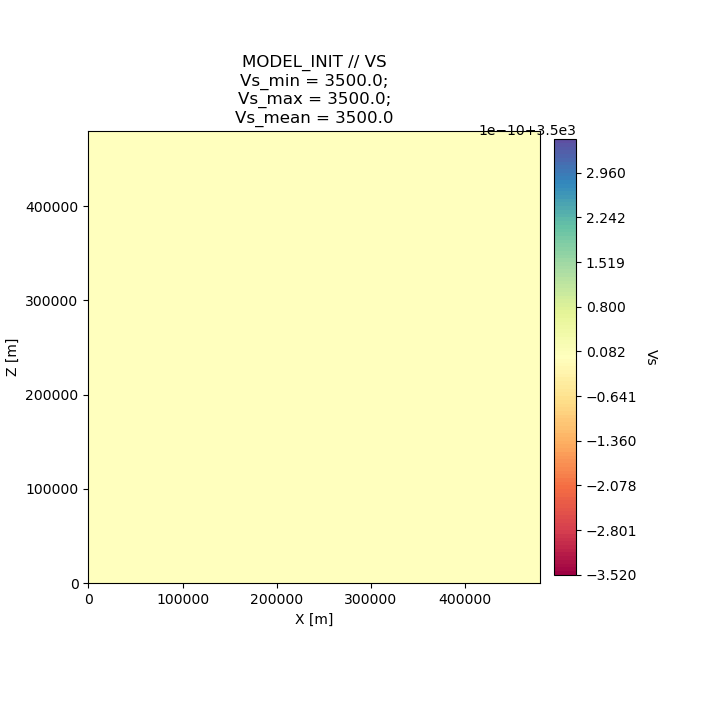

In [13]:
# Plot and open the initial homogeneous halfspace model
!seisflows plot2d MODEL_INIT vs --savefig m_init_vs.png
Image(filename='m_init_vs.png')

Figure(707.107x707.107)


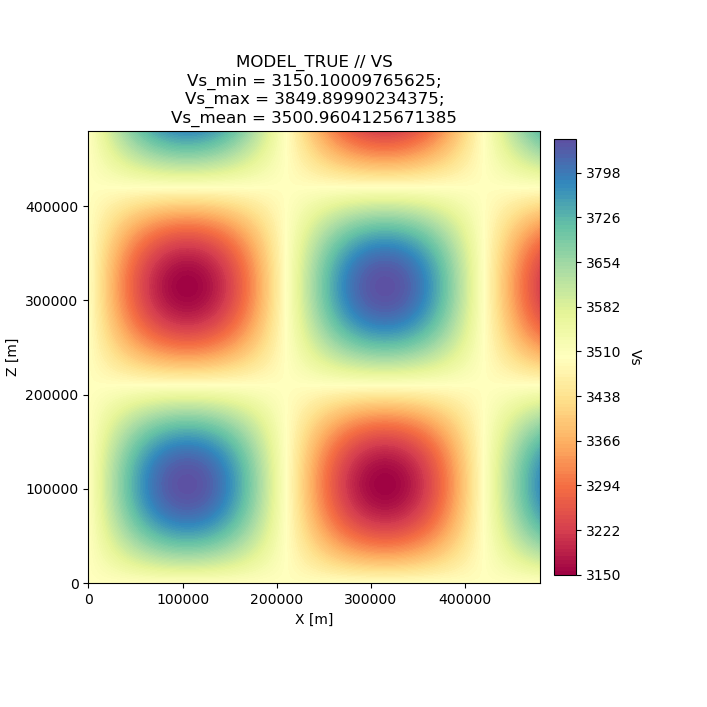

In [14]:
# Plot and open the initial homogeneous halfspace model
!seisflows plot2d MODEL_TRUE vs --savefig m_true_vs.png
Image(filename='m_true_vs.png')

Figure(707.107x707.107)


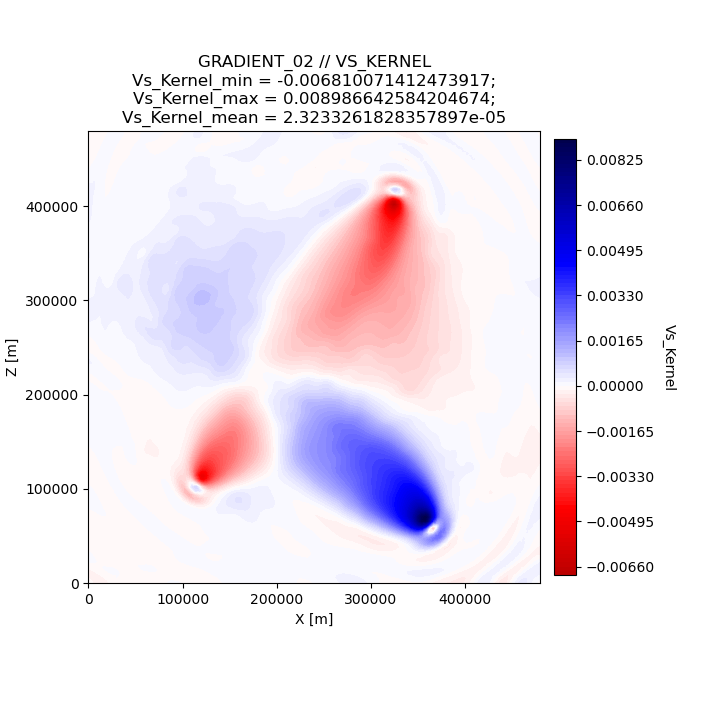

In [15]:
!seisflows plot2d GRADIENT_02 vs_kernel --savefig g_02_vs.png
Image(filename='g_02_vs.png')

Figure(707.107x707.107)


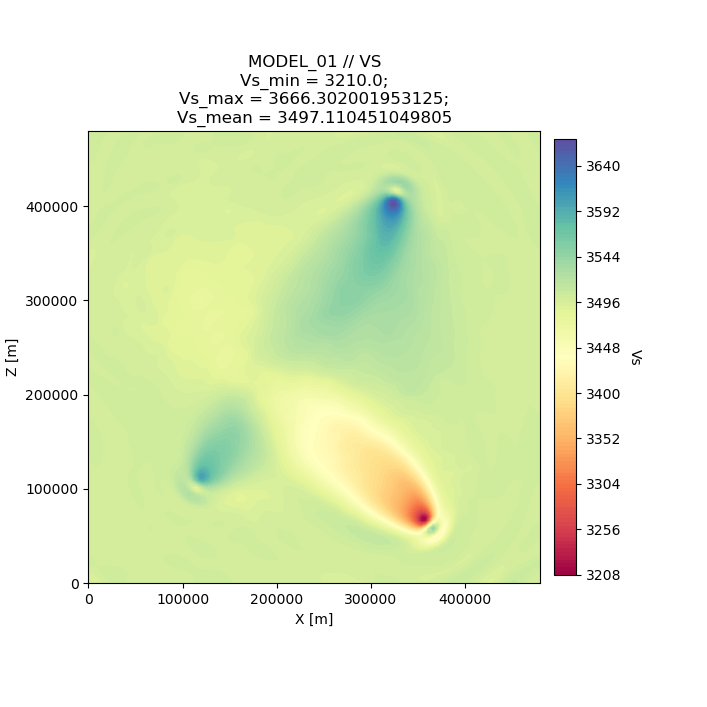

In [16]:
!seisflows plot2d MODEL_01 vs --savefig m_01_vs.png
Image(filename='m_01_vs.png')

Figure(707.107x707.107)


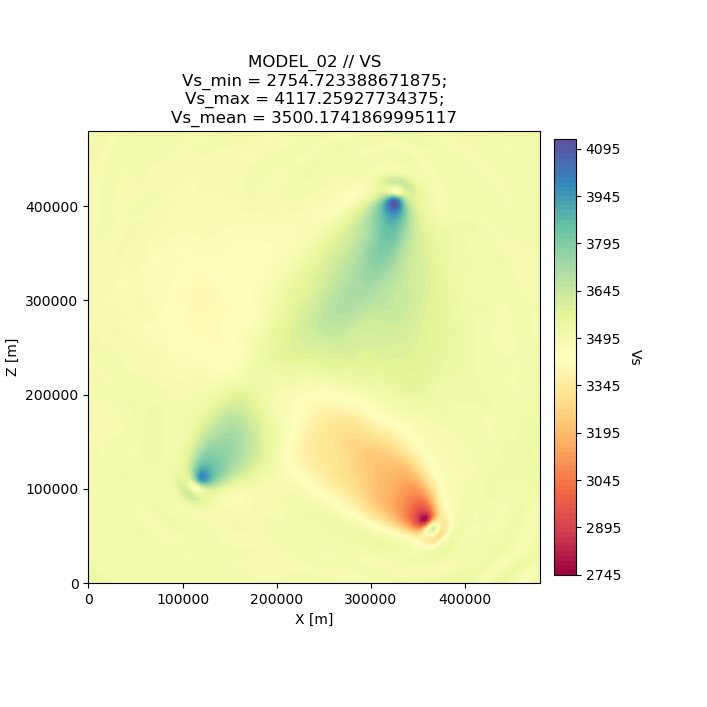

In [17]:
!seisflows plot2d MODEL_02 vs --savefig m_02_vs.png
Image(filename='m_02_vs.png')

Figure(707.107x707.107)


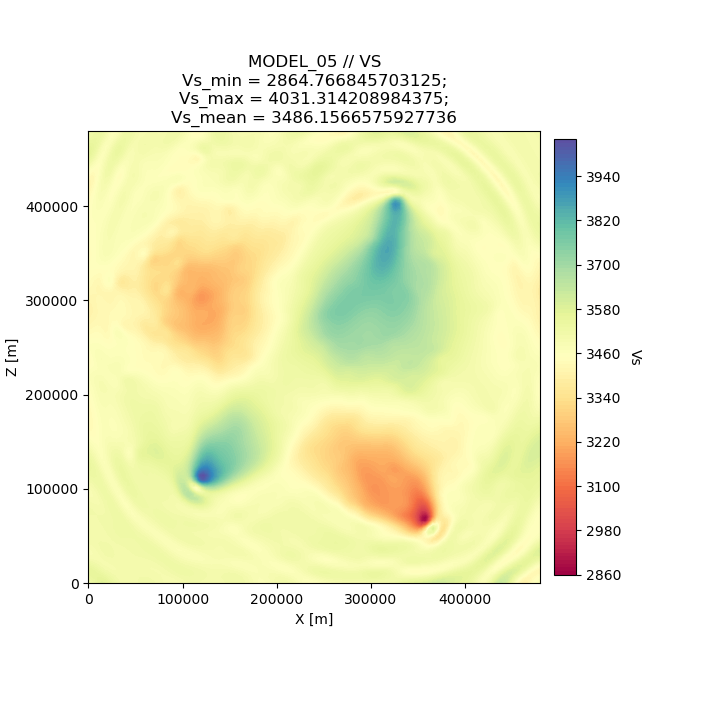

In [18]:
!seisflows plot2d MODEL_05 vs --savefig m_05_vs.png
Image(filename='m_05_vs.png')

In [20]:
print(time.time() - t0, "seconds wall time")

3825.8039462566376 seconds wall time
